# Training Wheel Exercise: Renal Cancer Data

Objective: 
Identifying relevant features is a common procedure in biological research (e.g gene expression and protein expression studies). Hence, comprehensive understanding of its workflow is mandatory. 

The purpose of this exercise is to provide an introduction into the conventional pipeline for pathway enrichment studies. More specifically, protein expression data will be analysed. Here, we are employing commonly-used feature selection methods e.g. t-test, recursive feature elimination, and selecting top proteins based on statistical p-value ranks. Subsequently, the frequently used hypergeometric enrichment tool will be utilised to evaluate enrichment of these protein features to pathways. 

The results from this exercise can also be used as a benchmark as we perform feature selection through "fuzzy-logic" tools in future studies. 

Footnote: 
This notebook also serves as a logbook for BS9001.

### Installation of packages 

We first install the packages that are required for analyses. Do ensure that pip is already installed, otherwise, download pip in the command line. 
Installation is not required if it's already done so. 

In [ ]:
#to install the libraries and packages required 
#before this run, download pip in command line 
!pip install pandas
!pip install sklearn 
!pip install matplotlib
!pip install numpy
!pip install bioinfokit
!pip install combat
!pip install seaborn

### Data preparation 
In this exercise, the well-studied renal cancer (RC) data will be used for analyses.

Some of the characteristics of the RC data include the following: 
- Protein expression data 
- "Cleaned" data 
- Two groups of patients: normal (control) and cancer (case) group
- Consist of 6 patients in each group with data obtained in duplicates 
- Consist of 3123 protein expression genes 
- Dimensions: 3123 rows x 24 columns  

Firstly, data transformation needs to be performed in order to render the RC data appropriate for subsequent analyses. 

In [1]:
#Data preparation 
%matplotlib inline
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from __future__ import division
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing

#transpose and convert first column as header, generate the feature tables
geneaggregate = pd.read_csv('RC_data.csv')
df = geneaggregate[sorted(geneaggregate.columns)]
dfT = df.swapaxes("index", "columns")
new_header = dfT.iloc[0] #grab the first row for the header
featuretable = dfT[1:] #take the data less the header row
featuretable.columns = new_header #set the header row as the df header

#store the protein expression values and protein gene names 
samples = featuretable.values
sample_names = featuretable.columns

print(featuretable)

Unnamed: 0              Q9UBE0  Q9BSJ8  P02656 O95741  P09651  P55809  Q15631  \
cancer_cc_patient1_rep1  40914   41185  274731   4969  103836  101089  102971   
cancer_cc_patient1_rep2  45120   42150  284693   5472  118185   97593  110008   
cancer_cc_patient2_rep1  44113  113386  141656   7872  162475  137794  112840   
cancer_cc_patient2_rep2  47835  139305  155864   7957  170174   99304  129621   
cancer_cc_patient3_rep1  26957   35891  161075   6111  101960   88960   92826   
cancer_cc_patient3_rep2  26005   30788  124223   3722   82866   68415   75856   
cancer_cc_patient6_rep1  35712   52750  194500   4094  118675  117222  142954   
cancer_cc_patient6_rep2  30517   33753  166061   3580   83659   85197   92312   
cancer_cc_patient7_rep1  38094   62466  177344   5878   95034   96055   97456   
cancer_cc_patient7_rep2  26654   45894  133566   4066   71776   54583   58171   
cancer_cc_patient8_rep1  48576  113950  121262   5700  175963  122041  114483   
cancer_cc_patient8_rep2  290

## Split the data by batches to hide the batch effects

In [2]:
#this block aims to separate the data by cases, in order to hide the class effects before performing quantile normalisation 
df_rep1 = df.iloc[:,[1,3,5,7,9,11,13,15,17,19,21,23]]
df_rep2 = df.iloc[:,[0,2,4,6,8,10,12,14,16,18,20,22,24]]
df_rep2 = df_rep2.set_index("Unnamed: 0")
df_rep1 = df_rep1.set_index(df_rep2.index)

In [6]:
from combat.pycombat import pycombat
#transform data into suitable format for batch correction 
#df2 = df.set_index("Unnamed: 0")
df_rep1_lc = np.log2(df_rep1)
df_rep2_lc = np.log2(df_rep2)
#perform batch correction


In [10]:
#main aim of this block is to perform z-normalisation through patients: correct way
#apply z-normalisation on transposed featuretable 
def z_score(df):
    # copy the dataframe
    df_std = df.copy()
    # apply the z-score method
    for column in df_std.columns:
        df_std[column] = (df_std[column] - df_std[column].mean()) / df_std[column].std()
        
    return df_std

#z normalise the batch 1 data
df_z_rep1_lc = z_score(df_rep1_lc)
df_z_rep1_lc = df_z_rep1_lc.T
# df_znormalised = df_znormalised_bypatients.T
# df_znormalised

#z normalise the batch 2 data
df_z_rep2_lc = z_score(df_rep2_lc)
df_z_rep2_lc = df_z_rep2_lc.T
df_z_rep1_lc

Unnamed: 0,Q9UBE0,Q9BSJ8,P02656,O95741,P09651,P55809,Q15631,Q96EY1,Q16706,Q9UID3,...,P50395,P21283,Q08257,P51161,Q9H2A2,P13010,O95182,P62241,Q14573,Q99436
cancer_cc_patient1_rep1,-0.400651,-0.395478,1.091618,-2.052727,0.329168,0.308158,0.322613,0.240693,-0.017399,-3.300473,...,1.336984,0.337098,1.509534,0.669552,-0.365245,0.917032,-0.013673,0.082334,-0.990049,-0.138265
cancer_cc_patient2_rep1,-0.538163,0.240814,0.424496,-1.960262,0.537643,0.401687,0.236831,-0.048585,0.136550,-2.657875,...,1.719436,-0.236366,1.717523,-0.209884,-0.552713,1.243721,0.194368,0.701797,-1.550855,0.077244
cancer_cc_patient3_rep1,-0.723080,-0.502453,0.654765,-1.867017,0.302301,0.197173,0.229962,-0.161674,0.460059,-2.963134,...,1.644244,0.205635,2.146035,-0.290371,-0.539425,1.078323,0.094519,0.128796,-1.743084,0.027452
cancer_cc_patient6_rep1,-0.549965,-0.246004,0.770792,-2.237755,0.385817,0.376218,0.530859,-0.116467,0.261870,-2.691147,...,1.563189,0.173589,2.269894,-0.253440,-0.533727,1.203704,-0.001551,0.292951,-1.663557,0.121207
cancer_cc_patient7_rep1,-0.493669,-0.105606,0.713157,-1.960064,0.223645,0.232030,0.243392,-0.242375,0.290067,-2.712164,...,1.410050,-0.084904,2.062203,-0.190323,-0.566597,1.098263,0.254814,0.116509,-1.574991,0.142288
cancer_cc_patient8_rep1,-0.444100,0.246474,0.296847,-2.179515,0.598402,0.302034,0.250254,0.338434,0.348805,-2.721821,...,1.582784,0.210741,1.585522,0.211091,-0.215485,1.313732,0.262694,0.887673,-1.700767,0.052097
normal_cc_patient1_rep1,-0.818076,-0.270067,0.864786,-1.033423,0.351047,0.397914,0.168226,0.151181,-0.347797,-3.023095,...,1.467228,0.451675,2.135657,-0.341642,0.351967,0.947966,0.634125,-0.041848,-1.448886,-0.212509
normal_cc_patient2_rep1,-0.633441,-0.089521,0.339548,-1.942457,0.313921,0.497838,0.214333,0.173700,-0.770326,-2.568882,...,1.462148,0.444050,1.944168,-0.302723,0.041345,0.904601,0.725682,0.244251,-1.363148,0.016695
normal_cc_patient3_rep1,-0.741926,-0.284252,1.021237,-1.221493,0.279345,0.431434,0.234741,0.205630,-0.784293,-2.811494,...,1.440866,0.449447,2.058069,-0.200083,0.220341,0.864134,0.774805,-0.060939,-1.302417,0.014474
normal_cc_patient6_rep1,-0.849782,-0.281780,0.706969,-1.714650,0.226590,0.582988,0.192499,0.207404,-0.866002,-2.746346,...,1.429873,0.403506,2.297587,-0.351234,0.424548,0.906931,0.647650,0.119621,-1.325048,0.098706


## PCA plot for Batch 1 

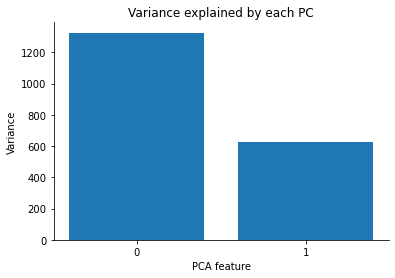

array([1325.06348804,  628.5612461 ])

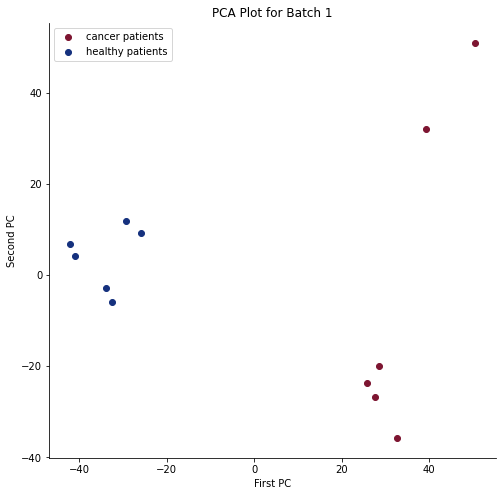

In [20]:
#This block performs the PCA test for batch 1 
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing

scaler = StandardScaler()
scaler.fit(df_z_rep1_lc)
scaled_df_z_rep1_lc = scaler.transform(df_z_rep1_lc)

pca = PCA(n_components=2)
pca.fit(scaled_df_z_rep1_lc)
scaled_df_z_rep1_lc

#run PCA 
x_pca = pca.transform(scaled_df_z_rep1_lc)
scaled_df_z_rep1_lc.shape

#observe variance explained byeach PC in a bar chart 
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_)
plt.xlabel('PCA feature')
plt.ylabel('Variance')
plt.xticks(features)
plt.title("Variance explained by each PC")
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.show()

#plot first two PCs in a scatter plot and separate c/non-c
plt.figure(figsize=(8,8))
plt.xlabel("First PC")
plt.ylabel("Second PC")

xs = x_pca[:,0]
ys = x_pca[:,1]

cancer = plt.scatter(xs[0:6], ys[0:6], c = "#7D1531", label = "cancer patients")
non_cancer = plt.scatter(xs[6:], ys[6:], c = "#15317E", label = "healthy patients")

plt.legend()
plt.title("PCA Plot for Batch 1")
plt.gca().spines['right'].set_visible(False) 
plt.gca().spines['top'].set_visible(False)
plt.show
pca.explained_variance_

## PCA plot for Batch 2

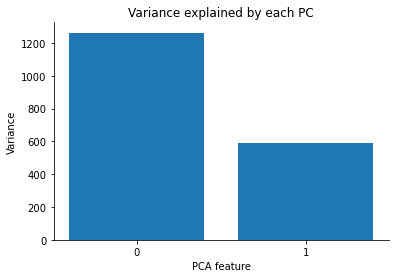

array([1262.44279893,  588.43911761])

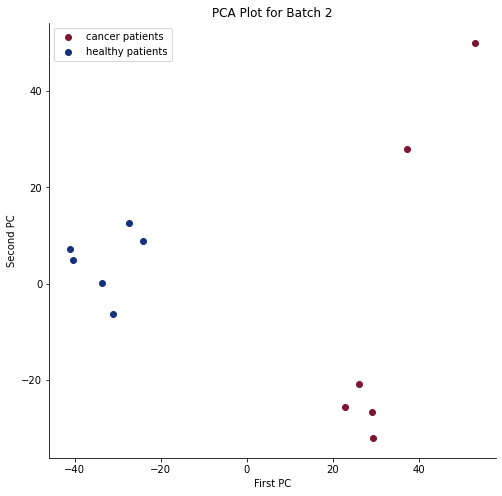

In [21]:
#This block performs the PCA test for batch 2
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing

scaler = StandardScaler()
scaler.fit(df_z_rep2_lc)
scaled_df_z_rep2_lc = scaler.transform(df_z_rep2_lc)

pca = PCA(n_components=2)
pca.fit(scaled_df_z_rep2_lc)
scaled_df_z_rep2_lc

#run PCA 
x_pca = pca.transform(scaled_df_z_rep2_lc)
scaled_df_z_rep2_lc.shape

#observe variance explained byeach PC in a bar chart 
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_)
plt.xlabel('PCA feature')
plt.ylabel('Variance')
plt.xticks(features)
plt.title("Variance explained by each PC")
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.show()

#plot first two PCs in a scatter plot and separate c/non-c
plt.figure(figsize=(8,8))
plt.xlabel("First PC")
plt.ylabel("Second PC")

xs = x_pca[:,0]
ys = x_pca[:,1]

cancer = plt.scatter(xs[0:6], ys[0:6], c = "#7D1531", label = "cancer patients")
non_cancer = plt.scatter(xs[6:], ys[6:], c = "#15317E", label = "healthy patients")

plt.legend()
plt.title("PCA Plot for Batch 2")
plt.gca().spines['right'].set_visible(False) 
plt.gca().spines['top'].set_visible(False)
plt.show
pca.explained_variance_

## Log Transform both Batch 1 and Batch 2

## Preparation of pathway data for mapping 
Pathway data are obtained from pathway databases to allow for enrichment analyses. 

In this study, the MSigDB was used to obtain our gene sets. The C5 ontology gene set (GO: BP) was obtained and will be used for downstream enrichment analyses.

In [15]:
#this block prepares the dictionaries for gene mapping 
pathway_gene = {}
pathway_source = {}

with open('c5.gobp.txt') as f:
    for line in f:
        genepathway = line.split()[0]
        source = line.split()[1]
        gene_symbols = line.split()[2:]
        pathway_source[genepathway] = source
        pathway_gene[genepathway] = gene_symbols
        
#this block manages the converted genes 
#turn the converted genes to a dataframe
converted_genes = pd.read_csv('converted genes.txt', sep = '\t')
converted_genes.to_numpy()
converted_genes

#sort the converted genes
sortedgenes = converted_genes.sort_values('From')
sortedgenes

#retain the unique genes symbols and converts it into a list
uniquegenesarray = sortedgenes.drop_duplicates(subset=['From'])
uniquegenesSym = uniquegenesarray["To"].tolist()
uniquegenesFrom = uniquegenesarray["From"].tolist()

In [16]:
#this block drops the columns that are not mapped for both batch 1 and batch 2 
for g in df_z_rep1:
    if g not in uniquegenesFrom:
        del df_z_rep1[g]

#this block drops the columns that are not mapped
for f in df_z_rep2:
    if f not in uniquegenesFrom:
        del df_z_rep2[f]

df_z_rep1_sorted = df_z_rep1[sorted(df_z_rep1.columns)]
df_z_rep2_sorted = df_z_rep2[sorted(df_z_rep2.columns)]

#rename the columns 
df_z_rep1_sorted.columns = uniquegenesSym
df_z_rep2_sorted.columns = uniquegenesSym

NameError: name 'df_z_rep1' is not defined

In [11]:
df_z_rep1_sorted

NameError: name 'df_z_rep1_sorted' is not defined